In [1]:
import player_model 
import draft_model 
import util
import final_model
from sklearn.metrics import brier_score_loss as brier_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.model_selection import train_test_split as tts
import pandas as pd
import numpy as np
%matplotlib inline

Load match data sourced from oracles elixir, and merge with player model information

In [2]:
match_data = util.load_match_data()
util.print_match_and_player_data(match_data)

,teamname,opponent,date,league,result,top_dif,jng_dif,mid_dif,bot_dif,sup_dif
0,ROX Tigers,KT Rolster,2017-01-17 07:10:23,LCK,0,-2.344660,-2.409820,-0.712900,-2.300489,-1.702800
1,KT Rolster,ROX Tigers,2017-01-17 07:10:23,LCK,1,2.344660,2.409820,0.712900,2.300489,1.702800
2,Longzhu Gaming,Samsung Galaxy,2017-01-17 10:04:07,LCK,1,0.248975,0.482163,0.973789,0.527127,1.420935
3,Samsung Galaxy,Longzhu Gaming,2017-01-17 10:04:07,LCK,0,-0.248975,-0.482163,-0.973789,-0.527127,-1.420935
4,bbq Olivers,MVP,2017-01-18 10:06:32,LCK,0,0.256832,-0.049755,0.121897,-1.606031,-0.198971


Fit the player model using the player differences. The logistic regression that uses draft information also interacts whether champions are most impactful in the early, mid, or late game.

In [3]:

player_model.calculate_positional_differences(match_data)
player_model.fit_player_model(match_data, use_draft_info=False)
player_model.fit_player_model(match_data, use_draft_info=True)
util.print_player_lead_probabilities(match_data)

,teamname,opponent,post_draft_top_lead_prob,post_draft_mid_lead_prob,post_draft_bot_lead_prob,draft_agnostic_top_lead_prob,draft_agnostic_mid_lead_prob,draft_agnostic_bot_lead_prob
0,ROX Tigers,KT Rolster,0.316691,0.365324,0.295454,0.327336,0.399318,0.321176
1,KT Rolster,ROX Tigers,0.699766,0.650405,0.694417,0.674956,0.604787,0.681533
2,Longzhu Gaming,Samsung Galaxy,0.475201,0.555779,0.626630,0.524044,0.572302,0.563270
3,Samsung Galaxy,Longzhu Gaming,0.522542,0.448256,0.389730,0.478557,0.431899,0.439795
4,bbq Olivers,MVP,0.560110,0.507998,0.365206,0.516312,0.508179,0.412866


Map each champion to its reduced role form. For each team sum over all comprising champions.

In [4]:
champion_mapping = draft_model.load_champion_mapping()
match_drafts = draft_model.reduce_team_drafts(match_data, champion_mapping)
util.print_team_reduced_drafts(match_drafts)

,id,team_Dives,team_Tanks,team_Damages,team_Enchanters,team_Picks,team_Pokes,team_Engages,team_Splitpushs,early_game,mid_game,late_game,ap,ad,no_damage_type
0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,2.0,0.0
1,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,3.0,1.0,2.0,2.0,0.0
2,2.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,3.0,0.0
3,3.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0
4,4.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,3.0,1.0,2.0,2.0,0.0


Cluster all teams' drafts into 7 clusters.

In [5]:
N_clusters = 7
match_drafts = draft_model.cluster_drafts(match_drafts, n_clusters=N_clusters)
util.print_draft_centroids(match_drafts)

,team_Dives,team_Tanks,team_Damages,team_Enchanters,team_Picks,team_Pokes,team_Engages,team_Splitpushs,early_game,mid_game,late_game,no_damage_type
team_comp,,,,,,,,,,,,
0,0.548780,1.295122,1.079268,0.413415,0.201220,0.451220,0.806098,0.204878,1.113415,1.926829,1.959756,1.0
1,0.659113,0.645243,0.587810,0.180309,0.777105,1.308263,0.762649,0.079508,2.445399,1.444813,1.109787,0.0
2,0.522190,0.660606,1.313001,1.070381,0.293451,0.539785,0.561877,0.038710,1.488563,1.263539,2.247898,0.0
3,0.998295,0.694970,1.017391,0.096675,0.545780,0.462234,1.133333,0.051321,1.066837,3.207502,0.725661,0.0
4,0.327380,1.926278,1.241307,0.052252,0.286719,0.740072,0.415542,0.010450,0.836975,1.836215,2.326810,0.0
5,0.409686,0.502618,2.028959,0.012435,0.302029,0.250164,1.492965,0.001145,1.275687,1.659031,2.065281,0.0
6,0.248384,0.745330,1.085309,0.210848,0.389188,0.542205,0.741559,1.037177,1.000180,1.811243,2.188578,0.0


Merge information from draft clusters and player model win probabilities, and the list of composition that played against each in the dataset.

In [6]:

full_data, list_of_comp_diffs = util.merge_team_and_draft(match_data, match_drafts, N_clusters)

Train draft agnostic control model and final post draft model

In [7]:
train, test = tts(full_data, test_size=0.2, random_state=1)
draft_agnostic_model = final_model.train_draft_agnostic_model(train)
post_draft_model = final_model.train_post_draft_model(train, list_of_comp_diffs, full_data)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6645716621035871
            Iterations: 70
            Function evaluations: 72
            Gradient evaluations: 70


In [8]:

final_model.predict_with_model(full_data, draft_agnostic_model, "draft_agnostic")
final_model.predict_with_model(full_data, post_draft_model, "post_draft")

# How much did a team improve their win probability through draft
full_data["draft_diff"] = full_data["post_draft_win_prob"] - full_data["draft_agnostic_win_prob"]

util.print_win_prob_model_outputs(full_data)

,teamname,opponent,result,draft_agnostic_win_prob,post_draft_win_prob,draft_diff
0,ROX Tigers,KT Rolster,0,0.498941,0.268739,-0.230202
1,KT Rolster,ROX Tigers,1,0.501059,0.731261,0.230202
2,Longzhu Gaming,Samsung Galaxy,1,0.521366,0.606424,0.085058
3,Samsung Galaxy,Longzhu Gaming,0,0.478634,0.393576,-0.085058
4,bbq Olivers,MVP,0,0.462730,0.428182,-0.034548


Print model statistics

In [9]:
# Using the same random state gives the same test train split
# We need to do this as the original model does not have the normalised win probs for each side of the match
train, test = tts(full_data, test_size=0.2, random_state=1)

def print_stats(model_name):
  print(f"""{model_name} Brier score: 
  {brier_score(test['result'], test[f'{model_name}_win_prob'])}\n
   {model_name} test accurary:
  {acc_score(test['result'], round(test[f'{model_name}_win_prob']))}
  """)

print_stats("draft_agnostic")
print("--------------------------")
print_stats("post_draft")

draft_agnostic Brier score: 
  0.24702090442169433

   draft_agnostic test accurary:
  0.5601598342459672
  
--------------------------
post_draft Brier score: 
  0.21313119164806818

   post_draft test accurary:
  0.6593162646144739
  


Import Bet 365 odds and adjust for the hold

In [10]:
bookie_odds = pd.read_csv("data/b365_odds.tsv", sep='\t')
bookie_odds["implied_win_prob"] = bookie_odds['implied_h_prob'] / (bookie_odds['implied_h_prob'] + bookie_odds['implied_a_prob'])
print("After adjusting for hold:")
print(f"""
Bookie Brier score:
{brier_score(bookie_odds['result'], bookie_odds['implied_win_prob'])}\n
Bookie accuracy
{acc_score(bookie_odds['result'], round(bookie_odds['implied_win_prob']))}
"""
)

After adjusting for hold:

Bookie Brier score:
0.22284981228499326

Bookie accuracy
0.6435495898583147



Ouput the calibration plot of the post draft model

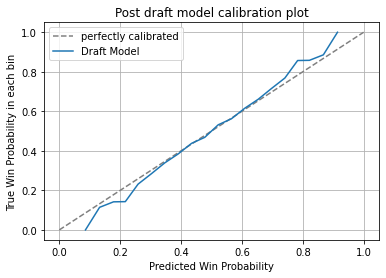

In [11]:
util.calibration_plot(full_data)

Output which teams in the LoL European Championship added the most expected wins as a result of draft through the 2022 Spring and Summer split

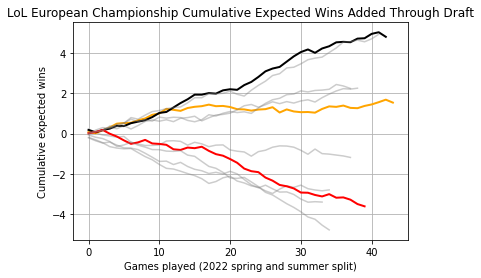

In [12]:
util.plot_cumulative_expected_wins_added_by_draft(full_data)